# 📘 Time-Series Forecasting Tutorial on US Air Passengers Dataset

This notebook is a **tutorial-style guide** to time-series forecasting using the classic **US Air Passengers** dataset.

We will:

- Load and explore a monthly passenger count dataset (`data/AirPassengers.csv`)
- Split it into training and test sets (last 12 months as test)
- Implement and compare **several forecasting methods** from:
  - **Classical statistics**
  - **Modern machine learning**
  - **Deep learning**
  - **Specialized time-series libraries**

## 🔧 Methods Covered

**Statistical / Classical Methods**
1. Simple Moving Average (SMA)
2. Weighted Moving Average (WMA)
3. Exponential Moving Average (EMA)
4. ARIMA (via `pmdarima`)
5. Prophet (additive model)

**Machine Learning Methods**
6. Random Forest (with lag features)
7. XGBoost (with lag features)

**Deep Learning**
8. LSTM (sequence modeling with Keras/TensorFlow)

At the end, we will:

- Compute **RMSE** (Root Mean Squared Error) for each method
- Build a **comparative table**
- Plot a **bar chart** comparing their performance


***
### Import required libraries

In [1]:
# !pip install scikit-learn statsmodels pmdarima prophet xgboost tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras import layers, models

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

***
### ✈️ Load US Air Passengers Dataset

This tutorial uses the **US Air Passengers dataset**, a classic benchmark in time-series analysis and forecasting.  
The dataset is available on Kaggle:

📌 **Source:** https://www.kaggle.com/datasets/brmil07/air-passengers-dataset


#### 📊 About the Dataset

The dataset contains **monthly totals of US airline passengers** from **January 1949 to December 1960**.  
This corresponds to **144 consecutive monthly observations**, making it a univariate numeric time-series suitable for classical and modern forecasting models.

🔢 **Dataset Columns**
- **Month** — Calendar month in the format `YYYY-MM`
- **Passengers** — Number of airline passengers (in thousands)


#### 📈 Why This Dataset Is Commonly Used

The Air Passengers dataset is widely used in forecasting tutorials because it exhibits:

✔ Clear upward **trend**  
Passenger numbers grow steadily over time due to post-war economic expansion and increased air travel.

✔ Strong **seasonality**  
Peaks occur during summer months, indicating consistent yearly traveling patterns.

✔ Realistic **noise and variability**  
It models real-world behavior better than synthetic data.

✔ Simplicity for teaching  
It is small, easy to visualize, and ideal for demonstrating statistical, machine learning, and deep-learning forecasting methods.


In [2]:
url = "https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/AirPassengers.csv"
df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()

Shape: (144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Preprocessing and Train–Test Split

We:

1. Convert the `Month` column to a `datetime` type.
2. Set it as the index to obtain a proper time series.
3. Rename the passenger column to `Passengers` for convenience.
4. Split the data so that the **last 12 months** are used as the **test set** and the rest as training data.


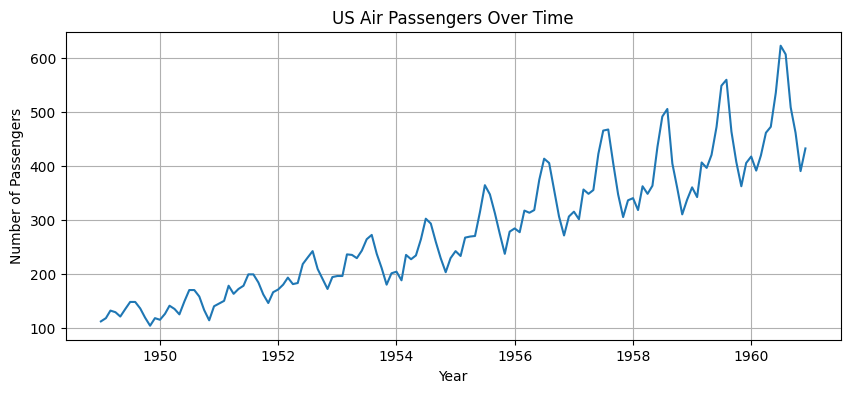

Train shape: (132, 1)
Test shape: (12, 1)


(            Passengers
 Month                 
 1959-08-01         559
 1959-09-01         463
 1959-10-01         407
 1959-11-01         362
 1959-12-01         405,
             Passengers
 Month                 
 1960-01-01         417
 1960-02-01         391
 1960-03-01         419
 1960-04-01         461
 1960-05-01         472)

In [3]:
# Convert Month to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

# Rename column for clarity
df.columns = ['Passengers']

# Basic plot
plt.figure(figsize=(10,4))
plt.plot(df['Passengers'])
plt.title('US Air Passengers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

# Train–test split: last 12 months as test
train = df.iloc[:-12]
test = df.iloc[-12:]

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.tail(), test.head()

In [4]:
results = {}
all_forecasts = {}  # to optionally store forecast series for plotting if needed

### Simple Moving Average (SMA)

**Idea:**  
The Simple Moving Average (SMA) forecasts future values by taking the **unweighted mean of the last *k* observations**.

For example, a 12-month SMA uses the last 12 months of passenger counts and averages them to produce a forecast.

**Formula:**  

$\text{SMA}_t = \frac{1}{k} \sum_{i=0}^{k-1} y_{t-i}$

**Pros:**
- Very easy to implement and explain.
- Useful for smoothing noisy data.

**Cons:**
- Ignores trend and seasonality.
- All points in the window are weighted equally (no recency preference).
- Poor for complex, non-stationary series like AirPassengers.

We will use a **12-month window** and then use the **last SMA value** as a constant forecast for the next 12 months.


In [5]:
window = 12

# Rolling mean over the training data
sma_series = train['Passengers'].rolling(window=window).mean()

# Use the last available SMA value as forecast for all 12 future months
last_sma = sma_series.iloc[-1]
sma_forecast = np.repeat(last_sma, len(test))

rmse_sma = np.sqrt(mean_squared_error(test['Passengers'], sma_forecast))
results['SMA'] = rmse_sma
all_forecasts['SMA'] = sma_forecast

print('SMA RMSE:', rmse_sma)

SMA RMSE: 88.47315977176355


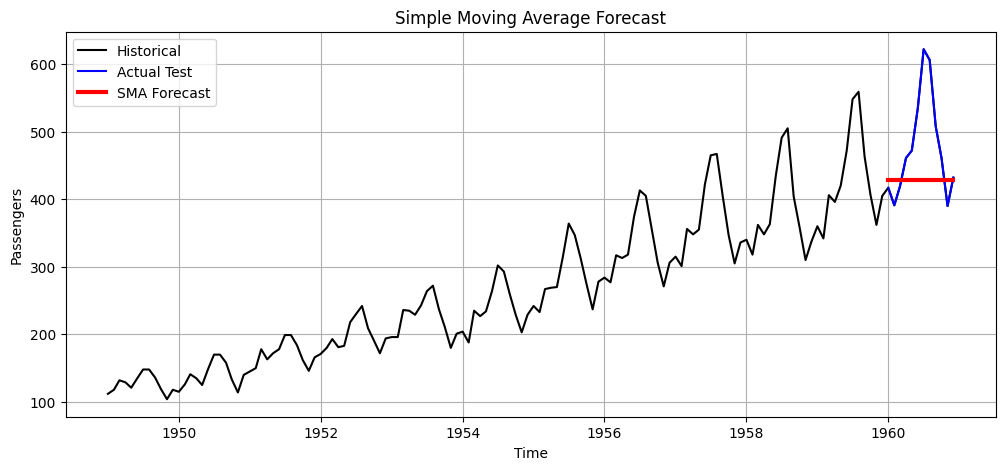

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["SMA"], label="SMA Forecast", color="red", linewidth=3)
plt.title("Simple Moving Average Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### Weighted Moving Average (WMA)

**Idea:**  
The Weighted Moving Average (WMA) is similar to SMA, but assigns **more weight to recent observations**.

For a 12-point WMA, we might assign weights: 1, 2, 3, ..., 12, giving the most recent month the highest weight.

**Formula:**  

$\text{WMA}_t = \frac{\sum_{i=0}^{k-1} w_i y_{t-i}}{\sum_{i=0}^{k-1} w_i}$

Where $ w_i $ are weights (larger for recent data).

**Pros:**
- Emphasizes recent patterns.
- Still simple and fast.

**Cons:**
- Does not explicitly model trend or seasonality.
- Choice of weights is heuristic.

We choose linear weights from 1 to 12, with the highest weight on the most recent month.


In [7]:
# Define linear weights for the last 12 months
window = 12
weights = np.arange(1, window + 1)

# Take last 12 points of the training set
last_12 = train['Passengers'].iloc[-window:].values

# Compute weighted average
wma_value = np.sum(last_12 * weights) / np.sum(weights)

wma_forecast = np.repeat(wma_value, len(test))

rmse_wma = np.sqrt(mean_squared_error(test['Passengers'], wma_forecast))
results['WMA'] = rmse_wma
all_forecasts['WMA'] = wma_forecast

print('WMA RMSE:', rmse_wma)

WMA RMSE: 83.63724169622995


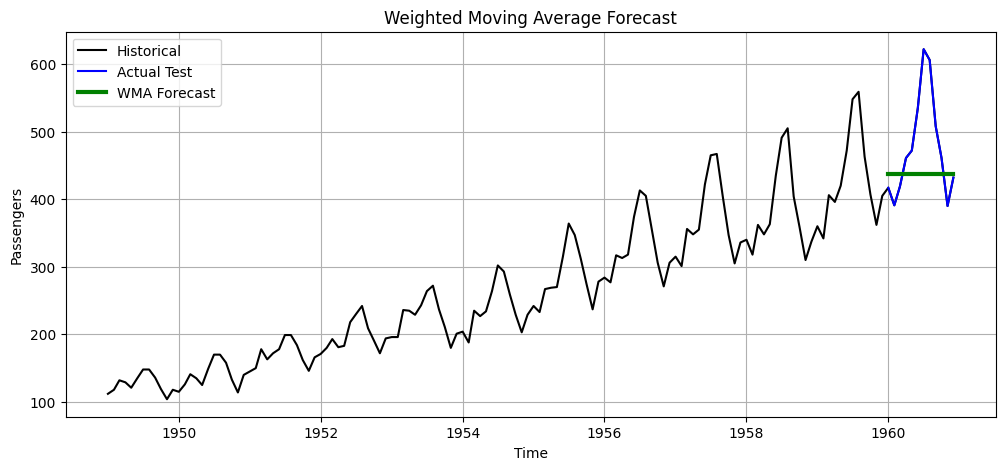

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], color="black", label="Historical")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["WMA"], label="WMA Forecast", color="green", linewidth=3)
plt.title("Weighted Moving Average Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### Exponential Moving Average (EMA)

**Idea:**  
The Exponential Moving Average (EMA) assigns **exponentially decaying weights** to past observations, so recent data has much higher influence than older data.

Unlike SMA/WMA, EMA reacts more quickly to level shifts.

**Formula (recursive form):**  

$
EMA_t = \alpha y_t + (1 - \alpha) EMA_{t-1}
$

Where:
- $ 0 < \alpha < 1 $ is the smoothing factor.

**Pros:**
- More responsive to level changes than SMA.
- Still simple, used heavily in finance and monitoring.

**Cons:**
- Does not explicitly model trend or seasonality.
- Choice of $ \alpha $ (or span) is heuristic.

We will compute a 12-period EMA on the training data and use its **last value** to forecast the next 12 months.


In [9]:
span = 12  # roughly similar to 12-month window
ema_series = train['Passengers'].ewm(span=span, adjust=False).mean()
last_ema = ema_series.iloc[-1]

ema_forecast = np.repeat(last_ema, len(test))

rmse_ema = np.sqrt(mean_squared_error(test['Passengers'], ema_forecast))
results['EMA'] = rmse_ema
all_forecasts['EMA'] = ema_forecast

print('EMA RMSE:', rmse_ema)

EMA RMSE: 90.80953938117352


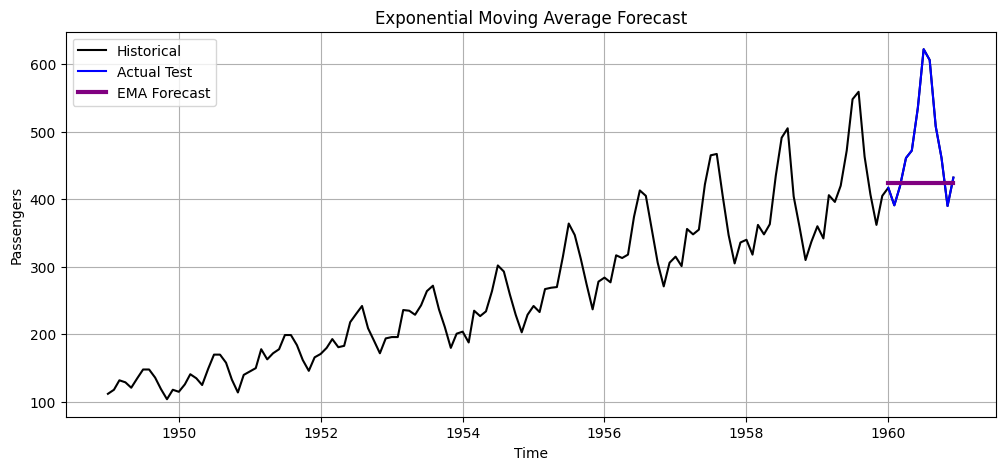

In [10]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["EMA"], label="EMA Forecast", color="purple", linewidth=3)
plt.title("Exponential Moving Average Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### ARIMA (Autoregressive Integrated Moving Average)

**Idea:**  
ARIMA is a classical time-series model that combines:

- **AR (Autoregressive):** past values (lags of the series)
- **I (Integrated):** differencing to remove trend
- **MA (Moving Average):** past forecast errors

An ARIMA(p, d, q) model is defined by:
- $ p $: autoregressive order
- $ d $: degree of differencing
- $ q $: moving average order

We will use **`pmdarima.auto_arima`** to automatically select good (p, d, q) and seasonal parameters.

**Pros:**
- Strong for linear, stationary(ish) time series with clear autocorrelation.
- Well-understood, interpretable.

**Cons:**
- Struggles with strong non-linearity.
- Manual order selection can be tedious (auto_arima helps).
- Seasonality must be modeled explicitly (SARIMA).

If `pmdarima` is not installed, this cell will skip and print a message.


In [11]:
# AirPassengers has strong monthly seasonality, so we use seasonal=True, m=12
y_train = train['Passengers']

model_arima = pm.auto_arima(
    y_train,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print('Selected ARIMA order:', model_arima.order)
print('Selected seasonal order:', model_arima.seasonal_order)

arima_forecast = model_arima.predict(n_periods=len(test))

rmse_arima = np.sqrt(mean_squared_error(test['Passengers'], arima_forecast))
results['ARIMA'] = rmse_arima
all_forecasts['ARIMA'] = arima_forecast

print('ARIMA RMSE:', rmse_arima)

Selected ARIMA order: (3, 0, 0)
Selected seasonal order: (0, 1, 0, 12)
ARIMA RMSE: 18.536468871472355


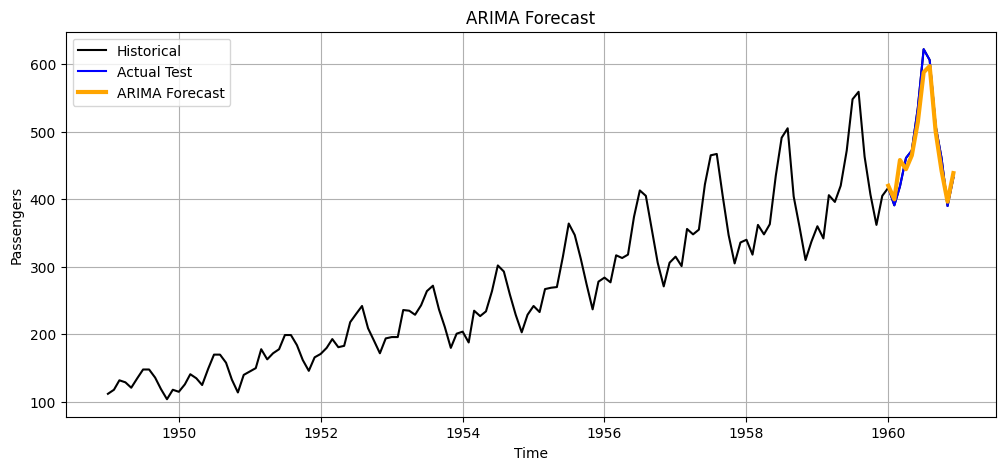

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["ARIMA"], label="ARIMA Forecast", color="orange", linewidth=3)
plt.title("ARIMA Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### Prophet (Additive Time-Series Model by Meta)

**Idea:**  
Prophet is a model developed by Meta (Facebook) designed for **business time series** with:

- Trend
- Multiple seasonalities (daily, weekly, yearly)
- Holiday effects

It uses an **additive decomposition model**:

$
y(t) = g(t) + s(t) + h(t) + \epsilon_t
$

Where:
- $ g(t) $: trend (piecewise linear or logistic)
- $ s(t) $: seasonality (Fourier series)
- $ h(t) $: holiday effects
- $ \epsilon_t $: noise

**Pros:**
- Easy to use, robust to missing data and outliers.
- Automatically handles trend and yearly seasonality.
- Great for many applied forecasting tasks.

**Cons:**
- Less flexible for highly irregular patterns.
- May be overkill for simple series.

If `prophet` is not installed, this section will be skipped.


In [13]:
# Prepare data in Prophet format: ds (date), y (value)
df_prophet = df.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
train_prophet = df_prophet.iloc[:-12]
test_prophet = df_prophet.iloc[-12:]

m = Prophet()
m.fit(train_prophet)

future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Extract predictions for the test period
prophet_forecast = forecast.iloc[-12:]['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))
results['Prophet'] = rmse_prophet
all_forecasts['Prophet'] = prophet_forecast

print('Prophet RMSE:', rmse_prophet)

15:42:43 - cmdstanpy - INFO - Chain [1] start processing
15:42:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 41.51469184777471


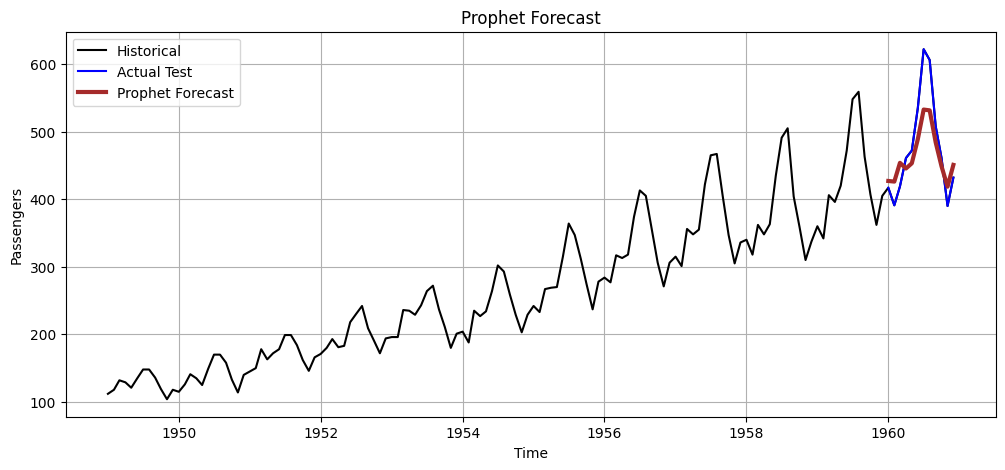

In [14]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["Prophet"], label="Prophet Forecast", color="brown", linewidth=3)
plt.title("Prophet Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### Random Forest with Lag Features

**Idea:**  
Random Forest is a tree-based ensemble method from machine learning. It is **not inherently time-series aware**, so we convert the series into a **supervised learning problem** by creating **lag features**.

Example:
- Input features: $ [y_{t-1}, y_{t-2}, ..., y_{t-12}] $
- Target: $ y_t $

We then train `RandomForestRegressor` to predict $ y_t $ from the lagged values.

**Pros:**
- Captures non-linear relationships.
- Naturally handles interactions between lags.

**Cons:**
- Ignores strict time-series structure (e.g., autocorrelation across residuals).
- Requires careful feature engineering (lags, rolling stats).

If `sklearn`'s RandomForestRegressor is not available, this section will be skipped.


In [15]:
def make_lag_features(series, n_lags=12):
    data = pd.DataFrame({'y': series})
    for lag in range(1, n_lags + 1):
        data[f'lag_{lag}'] = data['y'].shift(lag)
    data = data.dropna()
    return data

lagged = make_lag_features(df['Passengers'], n_lags=12)

# Align train/test based on time index
# Last 12 rows of original series correspond to test period
# So we split lagged data so that last 12 rows are test
X = lagged.drop('y', axis=1)
y = lagged['y']

X_train_rf = X.iloc[:-12]
X_test_rf = X.iloc[-12:]
y_train_rf = y.iloc[:-12]
y_test_rf = y.iloc[-12:]

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
rf.fit(X_train_rf, y_train_rf)
rf_preds = rf.predict(X_test_rf)

rmse_rf = np.sqrt(mean_squared_error(y_test_rf, rf_preds))
results['RandomForest'] = rmse_rf
all_forecasts['RandomForest'] = rf_preds

print('Random Forest RMSE:', rmse_rf)

Random Forest RMSE: 36.720503367908684


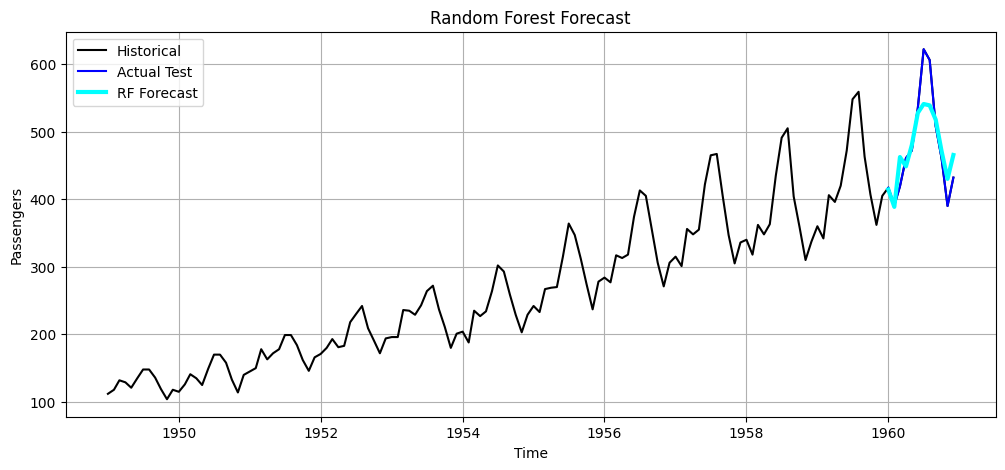

In [16]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["RandomForest"], label="RF Forecast", color="cyan", linewidth=3)
plt.title("Random Forest Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### XGBoost with Lag Features

**Idea:**  
XGBoost is a powerful gradient-boosted tree ensemble. Like Random Forest, it does not know about time by default, so we again use **lag features**.

We reuse the same lagged dataset prepared earlier and train an `XGBRegressor` model.

**Pros:**
- Often very strong performance on tabular data.
- Can capture complex non-linear patterns.

**Cons:**
- Needs hyperparameter tuning for best performance.
- Still relies on manual feature engineering for time-series structure.

If `xgboost` is not installed, this section will be skipped.


In [17]:
# Reuse X_train_rf, X_test_rf, y_train_rf, y_test_rf from above (lagged data)
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
xgb.fit(X_train_rf, y_train_rf)
xgb_preds = xgb.predict(X_test_rf)

rmse_xgb = np.sqrt(mean_squared_error(y_test_rf, xgb_preds))
results['XGBoost'] = rmse_xgb
all_forecasts['XGBoost'] = xgb_preds

print('XGBoost RMSE:', rmse_xgb)

XGBoost RMSE: 38.1794053409361


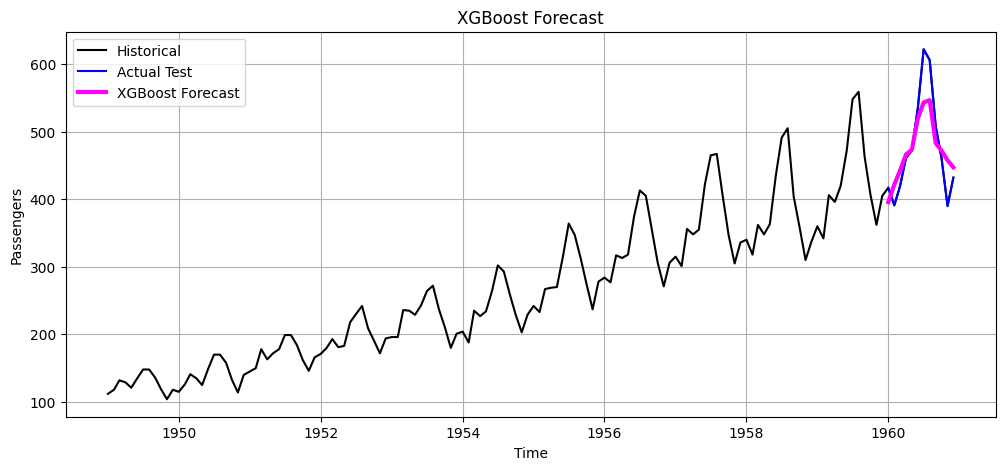

In [18]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["XGBoost"], label="XGBoost Forecast", color="magenta", linewidth=3)
plt.title("XGBoost Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### LSTM (Long Short-Term Memory Network)

**Idea:**  
LSTM is a type of Recurrent Neural Network (RNN) designed to capture **long-term dependencies** using gating mechanisms. It is well-suited to **sequence modeling**, including time-series forecasting.

We frame forecasting as:

- Input: last 12 months of passenger counts (sequence of length 12)
- Output: passenger count in the next month

We will:

1. Scale the series to [0, 1] for stable training.
2. Create supervised sequences:

$
X^{(i)} = [y_{i-12}, ..., y_{i-1}], \quad y^{(i)} = y_i
$

3. Train an LSTM on the training sequences.
4. Evaluate on the last 12 months (test period) using the corresponding input windows.

**Pros:**
- Learns non-linear temporal patterns.
- Handles longer-range dependencies better than simple RNN.

**Cons:**
- More complex, needs more data and tuning.
- Sensitive to scaling and architecture choices.

If TensorFlow/Keras is not installed, this section will be skipped.


TRAIN SAMPLES: (120, 12, 1)
TEST SAMPLES : (12, 12, 1)
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0217 - val_loss: 0.0305
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - val_loss: 0.0221
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0220
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0228
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0212
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0285
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0188
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0369
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0235
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0167
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0276
Epoch 12/50
27/27 

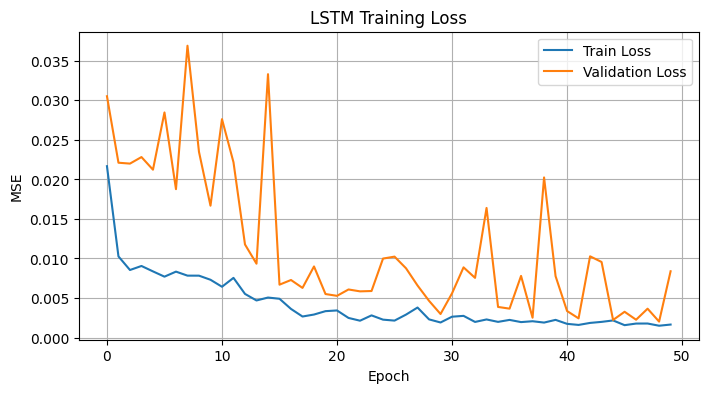

In [19]:
# ==========================================
# 1. Prepare data
# ==========================================
series = df['Passengers'].values.reshape(-1, 1)
n_total = len(series)
n_test = 12
n_train = n_total - n_test

# Scale using only the training portion
scaler = MinMaxScaler()
series_train_scaled = scaler.fit_transform(series[:n_train])
series_all_scaled = scaler.transform(series)

# ==========================================
# 2. Create sequences
# ==========================================
def create_lstm_sequences(data_scaled, n_lags=12):
    X_list, y_list = [], []
    for i in range(n_lags, len(data_scaled)):
        X_list.append(data_scaled[i-n_lags:i, 0])   # 12 values
        y_list.append(data_scaled[i, 0])            # next value
    return np.array(X_list), np.array(y_list)

# Full supervised dataset
X_all, y_all = create_lstm_sequences(series_all_scaled, n_lags=12)

# Proper train-test split
X_train_lstm = X_all[:-12]
X_test_lstm  = X_all[-12:]

y_train_lstm = y_all[:-12]
y_test_lstm  = y_all[-12:]

# Reshape for LSTM
X_train_lstm = X_train_lstm.reshape(-1, 12, 1)
X_test_lstm  = X_test_lstm.reshape(-1, 12, 1)

print("TRAIN SAMPLES:", X_train_lstm.shape)
print("TEST SAMPLES :", X_test_lstm.shape)

# ==========================================
# 3. Build LSTM model
# ==========================================
model_lstm = models.Sequential([
    layers.LSTM(64, activation='tanh', return_sequences=False, input_shape=(12,1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# ==========================================
# 4. Train LSTM (NOW WITH MULTIPLE EPOCHS)
# ==========================================
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,              # More epochs
    batch_size=4,           # Smaller batch size → more steps/epoch
    verbose=1,              # Show epochs
    validation_split=0.1
)

# ==========================================
# 5. Forecast
# ==========================================
lstm_preds_scaled = model_lstm.predict(X_test_lstm).flatten()

# inverse scale
lstm_preds = scaler.inverse_transform(lstm_preds_scaled.reshape(-1,1)).flatten()
y_test_true = series[n_train:]  # true last 12 months

# ==========================================
# 6. RMSE
# ==========================================
rmse_lstm = np.sqrt(mean_squared_error(y_test_true, lstm_preds))
results['LSTM'] = rmse_lstm
all_forecasts['LSTM'] = lstm_preds

print("🔥 LSTM RMSE:", rmse_lstm)

# ==========================================
# 7. Plot loss curve
# ==========================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

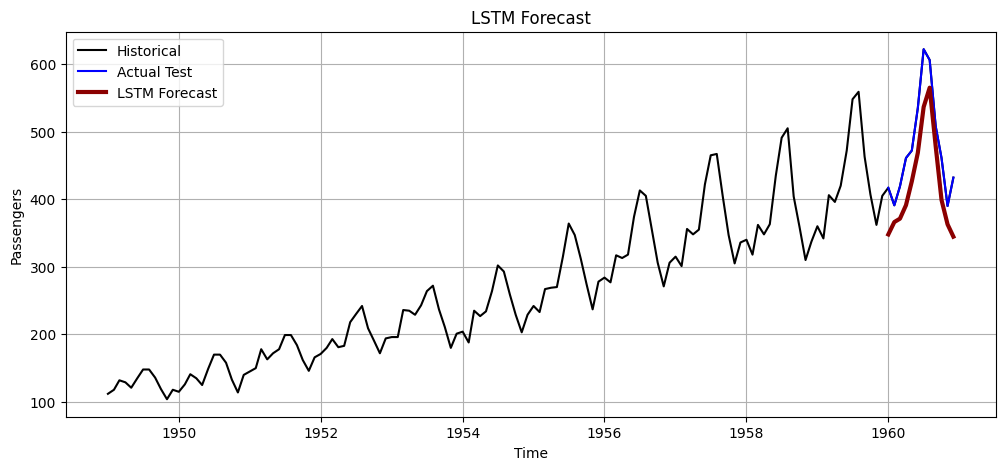

In [20]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Passengers"], label="Historical", color="black")
plt.plot(test.index, test["Passengers"], label="Actual Test", color="blue")
plt.plot(test.index, all_forecasts["LSTM"], label="LSTM Forecast", color="darkred", linewidth=3)
plt.title("LSTM Forecast")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### Comparison of All Methods (RMSE)

We now summarize the performance of all implemented methods using **RMSE** on the last 12 months of the series.

Lower RMSE indicates better forecasting accuracy on this test set.


In [21]:
# Build a DataFrame from the results dict
results_df = pd.DataFrame(
    [{'Method': k, 'RMSE': v} for k, v in results.items()]
).sort_values('RMSE')

results_df

,Method,RMSE
3,ARIMA,18.536469
5,RandomForest,36.720503
6,XGBoost,38.179405
4,Prophet,41.514692
7,LSTM,58.528520
1,WMA,83.637242
0,SMA,88.473160
2,EMA,90.809539


### RMSE Comparison Plot

The bar chart below visualizes the RMSE of each forecasting method for easier comparison.


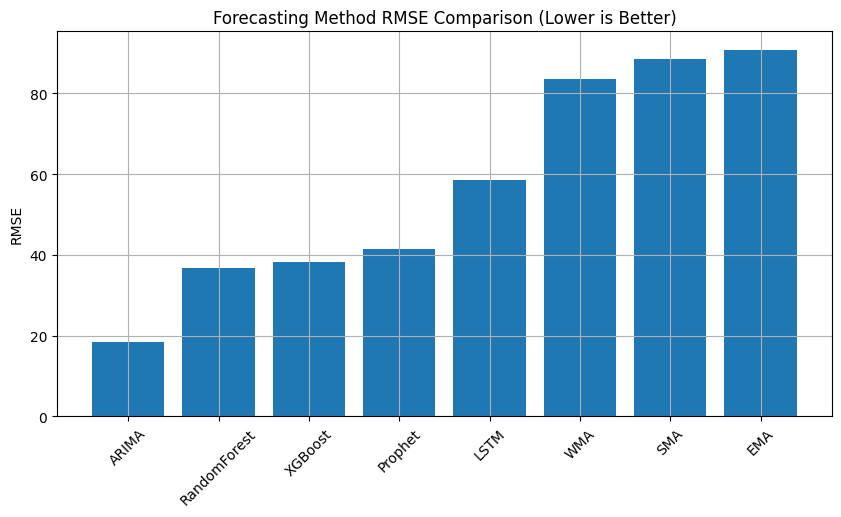

In [22]:
plt.figure(figsize=(10,5))
plt.bar(results_df['Method'], results_df['RMSE'])
plt.ylabel('RMSE')
plt.title('Forecasting Method RMSE Comparison (Lower is Better)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Visual Comparison of Forecasts

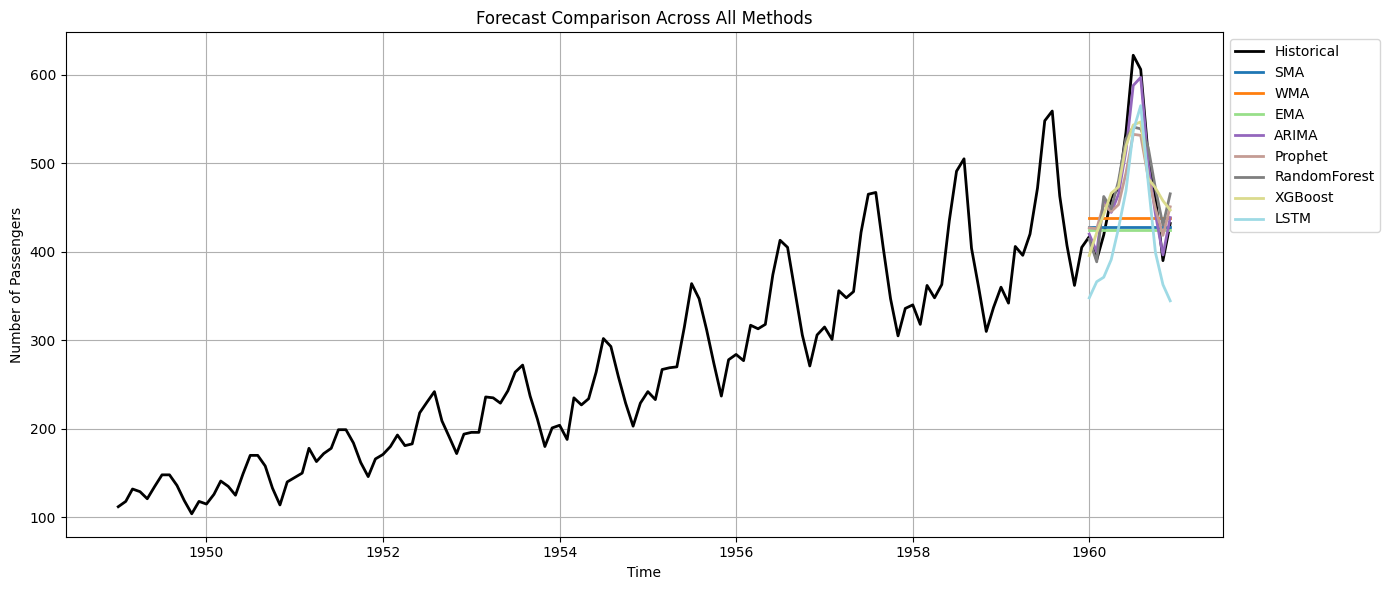

In [23]:
plt.figure(figsize=(14,6))

# Plot full historical time series
plt.plot(df.index, df["Passengers"], label="Historical", color="black", linewidth=2)

methods_to_plot = list(all_forecasts.keys())
colors = plt.cm.tab20(np.linspace(0, 1, len(methods_to_plot)))

# Plot each method's forecast on the test period
for method, color in zip(methods_to_plot, colors):
    forecast = all_forecasts[method]

    # Ensure forecast length matches test set
    forecast = np.array(forecast).flatten()
    
    plt.plot(
        test.index,
        forecast,
        label=method,
        linewidth=2,
        color=color
    )

plt.title("Forecast Comparison Across All Methods")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # place legend outside
plt.tight_layout()
plt.show()